In [4]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from IPython import display
%matplotlib inline

from scipy.stats import norm, laplace
from scipy.stats import gaussian_kde

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, log_loss, mean_absolute_error, mean_squared_error, brier_score_loss
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score, balanced_accuracy_score

from algorithms import *
from utils import *
from KMPE import *
from NN_functions import *

from tqdm import tqdm_notebook as tqdm
# from tqdm import tqdm as tqdm

import warnings
warnings.filterwarnings('ignore')

# Code for experiments

In [5]:
def experiment_synthetic(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, distribution='normal', 
                         n_networks=10, n_rep=10, find_alpha=True):
    """
    :param distribution: 'normal' or 'laplace'
    :find_alpha: if True, alpha^* is identified; if False, alpha^* is considered known and only corresponding 
        posteriors are estimated
    Most parameters, e.g. for implementations of algorithms, are hardcoded - change them in the function.
    """
    
    # defaults
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
    
    fixed_alpha = None
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            for i in range(n_rep):
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=i, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                target_mix = target_mix[target_mix != 2]
                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                cons_poster =  estimate_cons_poster(data[target_pu == 1].reshape(-1,), 
                                                    mu, s, distribution, alpha, cons_alpha)
                
                if not find_alpha:
                    fixed_alpha = cons_alpha
                res = dict()
                
                res = estimate_poster_cv(data, target_pu, estimator='ntc_methods', alpha=fixed_alpha,
                                         estimate_poster_options={'disp': False},
                                         estimate_diff_options={'tune': True,
                                                                'tune_diff_options': {'max_evals': 20, 'verbose': False,
                                                                                      'bw_mix_l': 0.01, 'bw_mix_h': 0.15, 
                                                                                      'bw_pos_l': 0.05, 'bw_pos_h': 0.25,
                                                                                      'threshold_l': 0.55, 'threshold_h': 0.55,
                                                                                      'k_neighbours_l': 100, 
                                                                                      'k_neighbours_h': 500,
                                                                                      'metric': brier_score_loss, 
                                                                                      'if_round': False,
                                                                                      'reweight': False}},
                                         estimate_preds_cv_options={'cv': 3, 'n_networks': n_networks,
                                                                    'lr': 0.0005, 'hid_dim': 32,
                                                                    'n_hid_layers': 1, 
                                                                    'random_state': n_networks*i},
                                         train_nn_options={'n_epochs': 200, 'batch_size': 16,
                                                           'n_batches': 15, 'n_early_stop': 3, 'disp': False})
                
#                 res['nnre'] = estimate_poster_cv(data, target_pu, estimator='nnre', alpha=cons_alpha,
#                                                  estimate_preds_cv_options={'cv': 3, 'n_networks': n_networks,
#                                                                             'lr': 0.0005, 'hid_dim': 32,
#                                                                             'n_hid_layers': 1, 
#                                                                             'random_state': n_networks*i},
#                                                  train_nn_options={'n_epochs': 100, 'batch_size': 32, 'loss_function': 'brier',
#                                                                    'n_batches': 15, 'n_early_stop': 5, 'disp': False})
                for key in res.keys():
                    est_alpha, poster = res[key]
                    
                    cur_result = [distribution, key, i, mu, s, alpha, cons_alpha, est_alpha]
                    cur_result.append(np.mean(poster))
                    cur_result.append(accuracy_score(target_mix, poster.round()))
                    cur_result.append(roc_auc_score(target_mix, poster))
                    cur_result.append(mean_absolute_error(cons_poster, poster))
                    cur_result.append(np.sqrt(mean_squared_error(cons_poster, poster)))
                    cur_result.append(log_loss(target_mix, poster))
                    cur_result.append(precision_score(target_mix, poster.round()))
                    cur_result.append(recall_score(target_mix, poster.round()))
                    cur_result.append(balanced_accuracy_score(target_mix, poster.round()))
                    cur_result.append(brier_score_loss(target_mix, poster))
                    
                    results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'estimator', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'est_alpha', 'mean_poster',
                                                'accuracy', 'roc', 'mae', 'rmse', 'log_loss', 'precision', 'recall',
                                                'accuracy_balanced', 'brier_score'])
    return df_results

In [3]:
res_normal = experiment_synthetic(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, 
                                  n_networks=10, n_rep=30, distribution='normal', 
#                                   find_alpha=True)
                                  find_alpha=False)

res_laplace = experiment_synthetic(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, 
                                   n_networks=10, n_rep=30, distribution='laplace', 
#                                   find_alpha=True)
                                   find_alpha=False)
res = pd.concat([res_normal, res_laplace])

res = res.round(5)
res.to_csv('experiment_synthetic_poster.csv', index=False, sep=';', decimal=',')

## KM

implementation is taken from http://web.eecs.umich.edu/~cscott/code.html#kmpe

In [4]:
def experiment_synthetic_KM(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, distribution='normal', 
                                n_rep=10, **kwargs):
    """
    :param distribution: 'normal' or 'laplace'
    """
    
    # defaults
    if alphas is None:
        alphas = [0.05, 0.25, 0.5, 0.75, 0.95]
    if dmu is None:
        dmu = [1, 2, 4]
    if ds is None:
        ds = [2, 4]
        
    params = []
    for mu in dmu:
        params.append((mu, 1))
    for s in ds:
        params.append((0, s))
        
    results = []
    for mu, s in tqdm(params):
        for alpha in tqdm(alphas):
            for i in range(n_rep):
                data, target_pu, target_mix = generate_data(mix_size, pos_size, alpha, random_state=i, 
                                                            delta_mu=mu, multiplier_s=s, distribution=distribution)
                cons_alpha = estimate_cons_alpha(mu, s, alpha, distribution)
                
                try:
                    KM_2 = wrapper(data[target_pu == 1], data[target_pu == 0], disp=False, 
                                   KM_1=False, KM_2=True, lambda_lower_bound=0.5, lambda_upper_bound=10)
                    KM_2 = 1 - KM_2
                except ValueError as e:
                    print(e)
                    KM_2 = np.nan
                
                cur_result = [distribution, i, mu, s, alpha, cons_alpha, KM_2]
                results.append(cur_result)
                
    df_results = pd.DataFrame(results, columns=['distribution', 'random_state', 
                                                'dmu', 'ds', 'alpha', 'cons_alpha', 'KM_2'])
    return df_results

In [2]:
res_normal = experiment_synthetic_KM(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, 
                                  n_rep=10, distribution='normal')
res_laplace = experiment_synthetic_KM(mix_size=2500, pos_size=500, alphas=None, dmu=None, ds=None, 
                                   n_rep=10, distribution='laplace')
res_KM = pd.concat([res_normal, res_laplace])

res_KM = res_KM.round(4)
res_KM.to_csv('KMPE_synthetic.csv', index=False, sep=';', decimal=',')

In [25]:
res_KM['KM_2_mae'] = (res_KM['cons_alpha'] - res_KM['KM_2']).abs()
res_KM_pivot_alpha = res_KM.pivot_table(index=['distribution', 'ds', 'dmu', 'alpha', 'cons_alpha', 'random_state'],
                        values=['KM_2_mae'])

res_pivot_alpha = res_KM_pivot_alpha.merge(res_pivot_alpha, left_index=True, right_index=True)

# Results of Experiments

In [66]:
res_pivot_alpha = pd.read_csv('experimental_data//alpha_synth.csv', sep=';', decimal=',')
res_pivot_mae = pd.read_csv('experimental_data//mae_synth.csv', sep=';', decimal=',')

## alpha

In [60]:
params = ((1, 1), (2, 1), (4, 1), (0, 2), (0, 4))
def plot_results_alpha_synthetic(res_plt, distribution, ylims=None, reverse_alpha=False, save_name=None, dpi=300):
    
    if distribution == 'laplace':
        symbol = 'L'
    elif distribution == 'normal':
        symbol = 'N'
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
        
    if ylims is None:
        ylims = {}
    
    fig = plt.figure(0)
    gridspec.GridSpec(2,6)
    fig.set_size_inches(w=20, h=12)
    fig.legend(handles=(Line2D([], [], linestyle='-', color='w', marker='.'),
                        Line2D([], [], linestyle=':', color='b', marker='x'),
                        Line2D([], [], linestyle='--', color='r', marker='s'),
                        Line2D([], [], linestyle='-.', color='k', marker='o'),
                        Line2D([], [], linestyle='-.', color='g', marker='^')),
               labels=('$f_p = {}(0, 1)$'.format(symbol), 'EN-em', 'KM2', 'DEDPUL', 'DEDPUL-random'),
               bbox_to_anchor=(0.905, 0.325),
               fontsize='xx-large')

    for i, (mu, s) in enumerate(params[:3]):
        res_plt_cur = res_plt[(res_plt['distribution'] == distribution) & (res_plt['dmu'] == mu) &(res_plt['ds'] == s)]
        plt.subplot2grid((2,6), (0,2*i), colspan=2, rowspan=1)
        plt.title("$f_n = {}({}, {})$".format(symbol, mu, s), fontdict={'fontsize': 17})

        plt.plot(res_plt_cur['alpha'], res_plt_cur['em_en'], 'bx:')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['KM_2_mae'], 'rs--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['random_dedpul'], 'g^-.')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-.')
        
        plt.xticks((0.05, 0.25, 0.5, 0.75, 0.95))
        plt.xlim(0, 1)
        if i in ylims.keys():
            plt.ylim(0, ylims[i])

    for i, (mu, s) in enumerate(params[3:]):  
        res_plt_cur = res_plt[(res_plt['distribution'] == distribution) & (res_plt['dmu'] == mu) &(res_plt['ds'] == s)]
        plt.subplot2grid((2,6), (1,0+2*i), colspan=2, rowspan=1)
        plt.title("$f_n = {}({}, {})$".format(symbol, mu, s), fontdict={'fontsize': 17})

        plt.plot(res_plt_cur['alpha'], res_plt_cur['em_en'], 'bx:')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['KM_2_mae'], 'rs--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['random_dedpul'], 'g^-.')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-.')
        
        plt.xticks(res_plt_cur['alpha'].unique())
        plt.xlim(0, 1)
        if i + 3 in ylims.keys():
            plt.ylim(0, ylims[i + 3])
        
    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)

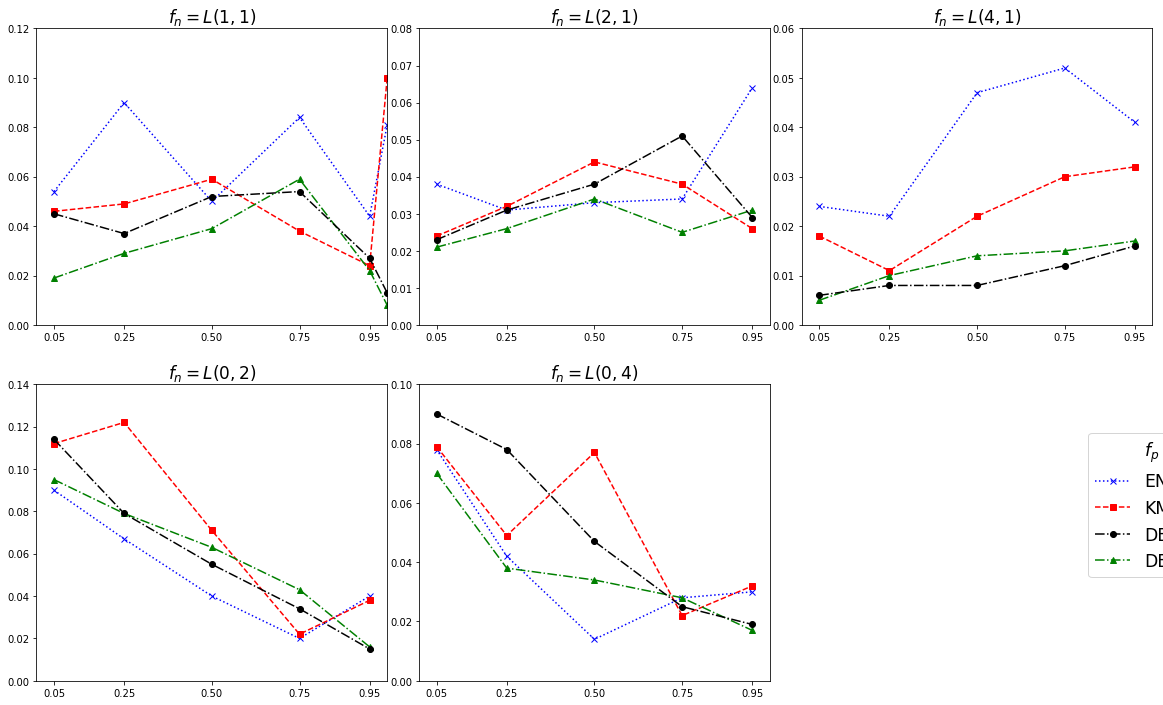

In [61]:
plot_results_alpha_synthetic(res_pivot_alpha.copy().reset_index(), 'laplace', reverse_alpha=True,
                       ylims={0: 0.12, 1: 0.08, 2: 0.06, 3: 0.14, 4: 0.1})#, save_name='laplace_alpha')
# [res_pivot_alpha.reset_index()['alpha'] != 0]

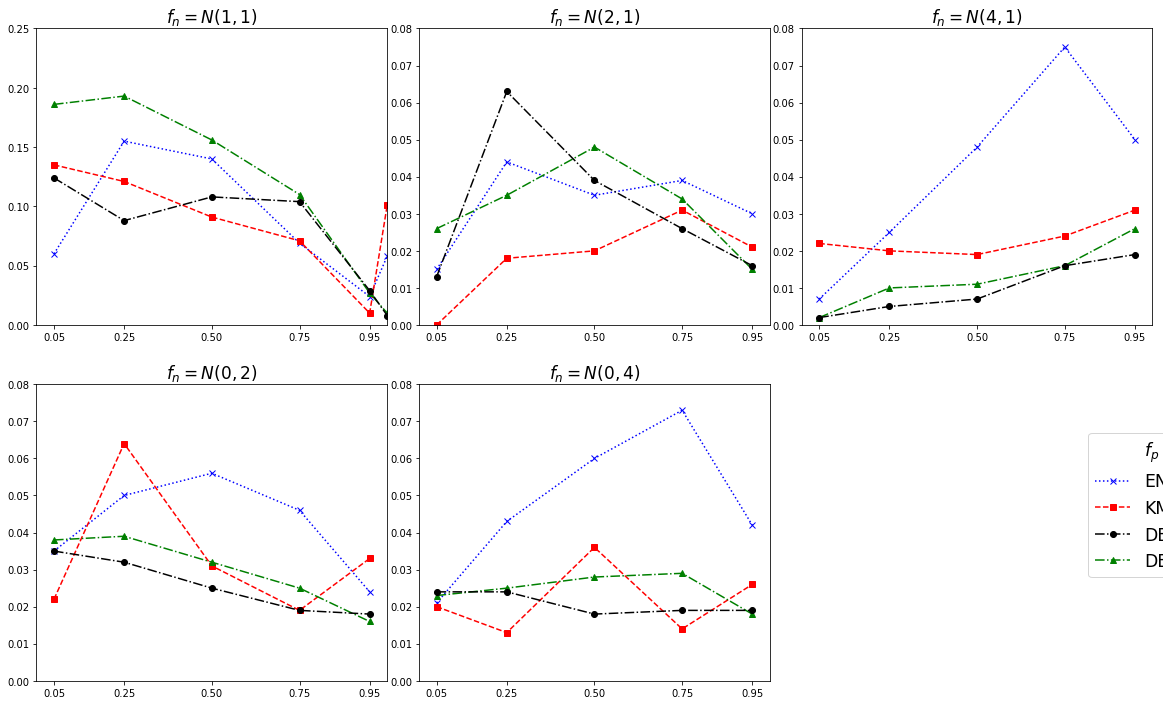

In [62]:
plot_results_alpha_synthetic(res_pivot_alpha.copy().reset_index(), 'normal', reverse_alpha=True,
                       ylims={0: 0.25, 1: 0.08, 2: 0.08, 3: 0.08, 4: 0.08})#, save_name='normal_alpha')

## mae

In [63]:
params = ((1, 1), (2, 1), (4, 1), (0, 2), (0, 4))
def plot_results_mae_synthetic(res_plt, distribution, ylims=None, reverse_alpha=False, save_name=None, dpi=300):
    
    if distribution == 'laplace':
        symbol = 'L'
    elif distribution == 'normal':
        symbol = 'N'
    
    if reverse_alpha:
        # by default all estimates are computed for negative priors; here convert them to positive priors
        res_plt['alpha'] = 1 - res_plt['alpha']
        
    if ylims is None:
        ylims = {}
    
    fig = plt.figure(0)
    gridspec.GridSpec(2,6)
    fig.set_size_inches(w=20, h=12)
    fig.legend(handles=(Line2D([], [], linestyle='-', color='w', marker='.'),
        Line2D([], [], linestyle=':', color='b', marker='x'),
        Line2D([], [], linestyle='--', color='y', marker='s'),
        Line2D([], [], linestyle='--', color='orange', marker='*'),
        Line2D([], [], linestyle='-.', color='k', marker='o'),
        Line2D([], [], linestyle='-.', color='g', marker='^')),
              labels=('$f_p = {}(0, 1)$'.format(symbol), 'EN', 'nnRE-brier', 'nnRE-sigmoid', 'DEDPUL', 'DEDPUL-random'),
              bbox_to_anchor=(0.905, 0.325),
              fontsize='xx-large')
    
    for i, (mu, s) in enumerate(params[:3]):
        res_plt_cur = res_plt[(res_plt['distribution'] == distribution) & (res_plt['dmu'] == mu) &(res_plt['ds'] == s)]
        plt.subplot2grid((2,6), (0,2*i), colspan=2, rowspan=1)
        plt.title("$f_n = {}({}, {})$".format(symbol, mu, s), fontdict={'fontsize': 17})

        plt.plot(res_plt_cur['alpha'], res_plt_cur['en'], 'bx:')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['brier_nnre'], 'ys--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['sigmoid_nnre'], c='orange', marker='*', ls='--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-.')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['random_dedpul'], 'g^-.')
        
        plt.xticks(res_plt_cur['alpha'].unique())
        plt.xlim(0, 1)
        if i in ylims.keys():
            plt.ylim(0, ylims[i])

    for i, (mu, s) in enumerate(params[3:]):  
        res_plt_cur = res_plt[(res_plt['distribution'] == distribution) & (res_plt['dmu'] == mu) &(res_plt['ds'] == s)]
        plt.subplot2grid((2,6), (1,0+2*i), colspan=2, rowspan=1)
        plt.title("$f_n = {}({}, {})$".format(symbol, mu, s), fontdict={'fontsize': 17})

        plt.plot(res_plt_cur['alpha'], res_plt_cur['en'], 'bx:')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['brier_nnre'], 'ys--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['sigmoid_nnre'], c='orange', marker='*', ls='--')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['dedpul'], 'ko-.')
        plt.plot(res_plt_cur['alpha'], res_plt_cur['random_dedpul'], 'g^-.')
        
        plt.xticks(res_plt_cur['alpha'].unique())
        plt.xlim(0, 1)
        if i + 3 in ylims.keys():
            plt.ylim(0, ylims[i + 3])
        
    if save_name:
        plt.savefig(save_name + '.png', dpi=dpi)

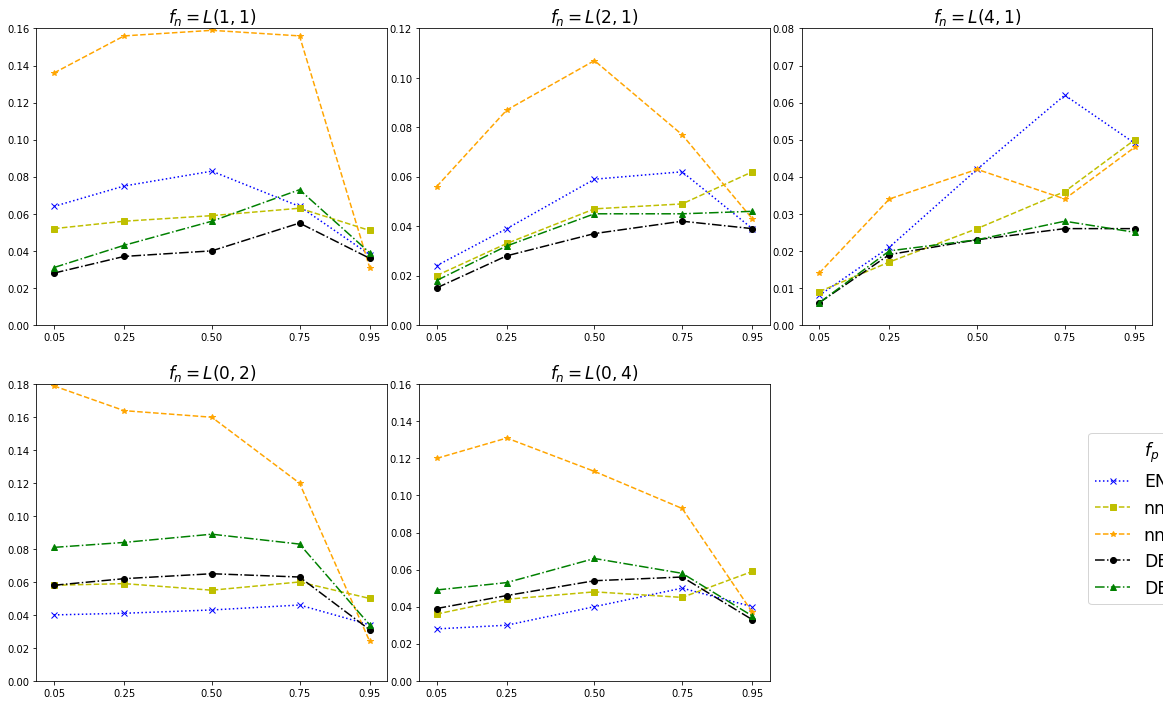

In [64]:
plot_results_mae_synthetic(res_pivot_mae.copy().reset_index(), 'laplace', reverse_alpha=True,
                       ylims={0: 0.16, 1: 0.12, 2: 0.08, 3: 0.18, 4: 0.16})#, save_name='laplace_mae')

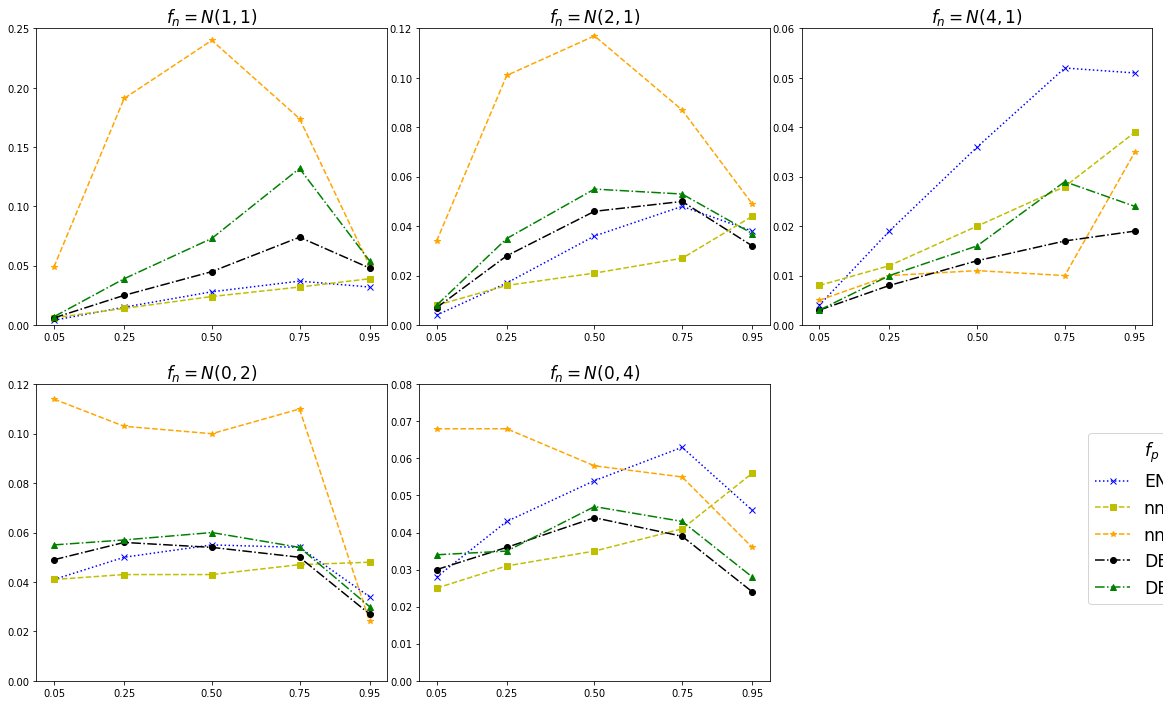

In [65]:
plot_results_mae_synthetic(res_pivot_mae.copy().reset_index(), 'normal', reverse_alpha=True,
                       ylims={0: 0.25, 1: 0.12, 2: 0.06, 3: 0.12, 4: 0.08})#, save_name='normal_mae')

## ac

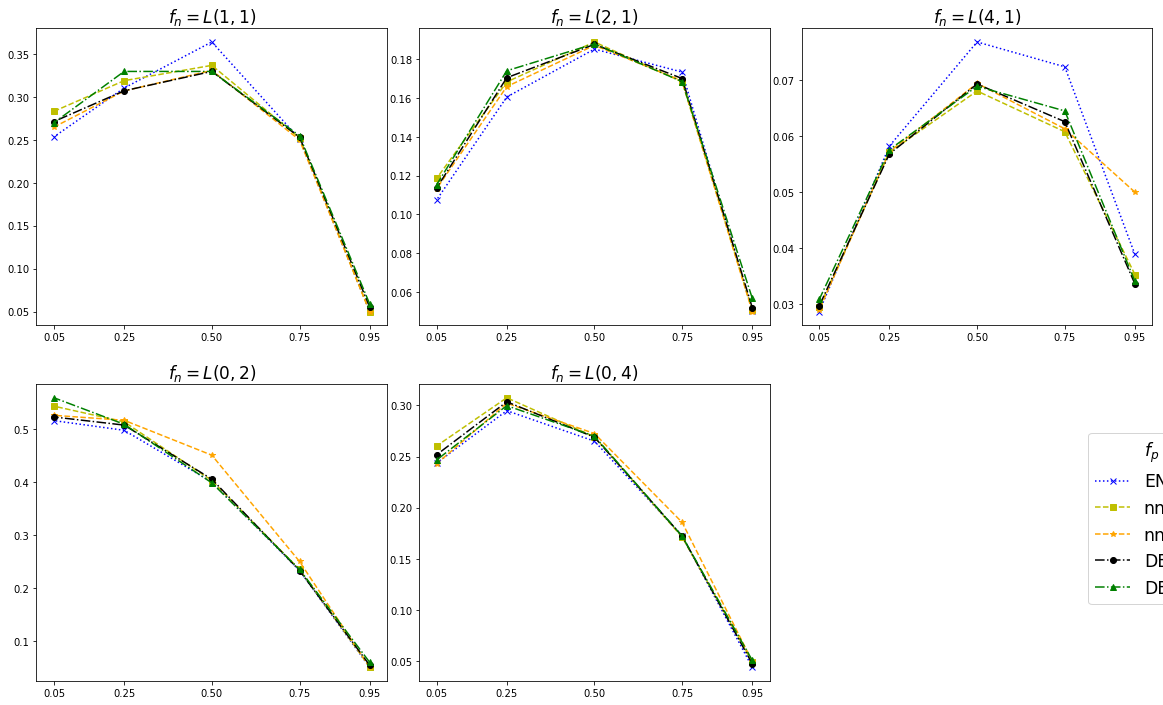

In [20]:
plot_results_mae_synthetic(res_pivot_bac.copy().reset_index(), 'laplace', reverse_alpha=True,
                       ylims={})#, save_name='laplace_bac')

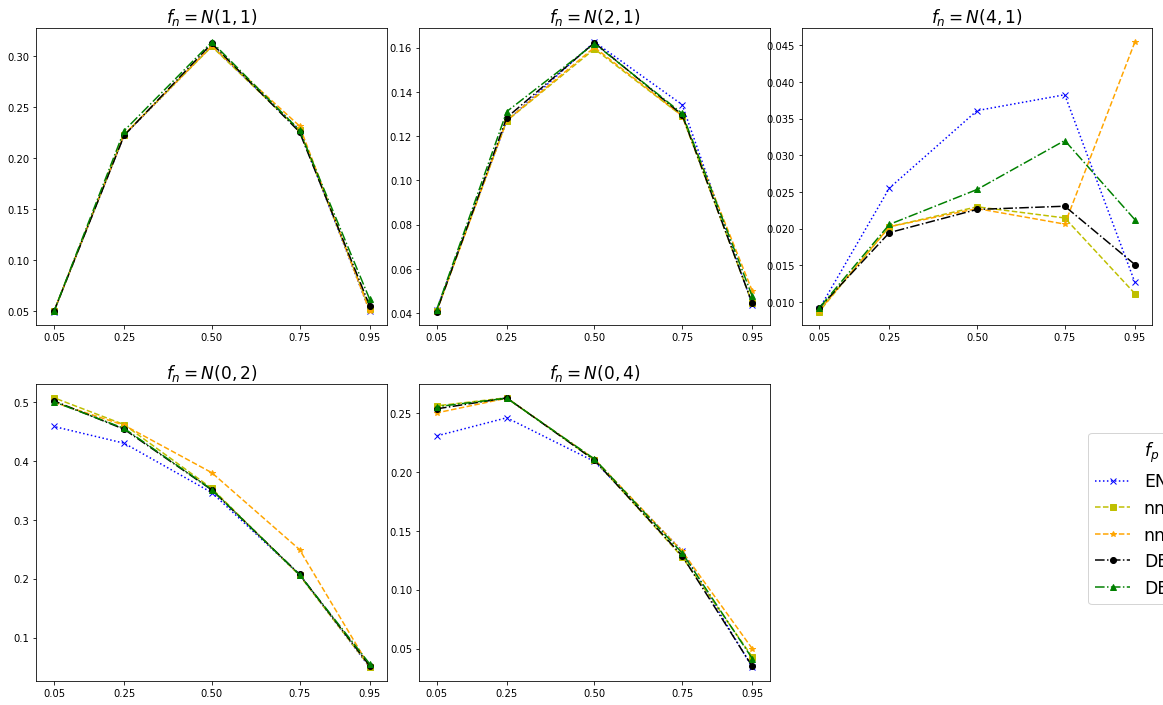

In [21]:
plot_results_mae_synthetic(res_pivot_bac.copy().reset_index(), 'normal', reverse_alpha=True,
                       ylims={})#, save_name='normal_bac')